In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as it
import re
from pathlib import Path

def mean(l):
    return sum(l) / len(l)


Following runs on profiling results_nodeterm

In [ ]:
# Parse results

results_dir = Path('results/results_nodeterm')

stoch_range = np.arange(10, 100, 10)
batch_range = np.arange(2, 12, 2)

dataset_paths = results_dir.glob('run_*.res')
baseline_path = results_dir / 'single_run.res'
noinst_path = results_dir / 'noinst_run.res'
baseline_dict = parse_baseline_res(baseline_path)
noinst_dict = parse_baseline_res(noinst_path)
testname_size = len(baseline_dict)

complete_run_dict = {}


def parse_baseline_res(fpath):
    header = re.compile(r'--> Test (\S+) <--')
    time = re.compile(r'Time:\s*(.*)')
    
    with open(fpath, 'r') as f:
        lines = list(f.readlines())
        
    run_results = [lines[i::2] for i in range(2)]
    compiler = [(header, str), (time, float)]
    full_results = [[compiler[i][1](compiler[i][0].match(elems).group(1)) \
                         for elems in run_key] for i, run_key in enumerate(run_results)]
    full_results[0] = [Path(x).name.split('.')[0] for x in full_results[0]]
    baseline_dict = dict(zip(*full_results))
    print(baseline_dict)
    return baseline_dict
        

    
def parse_batch_res(lines):
    header = re.compile(r'<-- Batch: (\S+) -->')
    max_time = re.compile(r'Max Time:\s*(.*)')
    accuracy = re.compile(r'Accuracy:\s*(.*)')
    
    run_results = [lines[i::3] for i in range(3)]

    compiler = [(header, str), (max_time, float), (accuracy, float)]
    full_results = [[compiler[i][1](compiler[i][0].match(elems).group(1)) \
                         for elems in run_key] for i, run_key in enumerate(run_results)]
    
    test_names = sorted(list(set(full_results[0])))
    num_tests = len(test_names)
    
    comp_results = [full_results[0][:num_tests]] + \
                    [[mean(full_results[j][i::num_tests]) for i in range(num_tests)] for j in [1,2]]
   
    run_dict = { i[0]: i[1:] for i in zip(*comp_results) }
    return run_dict

    
    

for stoch, batch_size in it.product(stoch_range, batch_range):
    stoch_idx = np.where(stoch_range == stoch)[0][0]
    batch_idx = np.where(batch_range == batch_size)[0][0]
    #print(stoch, batch_size)
    
    runs_content = []
    for dpath in results_dir.glob(f"run_*_{stoch}_{batch_size}.res"):
        with open(dpath) as f:
            runs_content += list(f.readlines())
    run_dict = parse_batch_res(runs_content)
    print(run_dict)
    
    for key, res in run_dict.items():
        if key not in complete_run_dict:
            complete_run_dict[key] = np.empty([stoch_range.size, batch_range.size, 2])
        complete_run_dict[key][stoch_idx][batch_idx][:] = np.array(res)

# Overhead compute relative to baseline
#for key, res in complete_run_dict.items():
#    res[:,:,0] /= baseline_dict[key]


In [ ]:
target_accuracies = np.array([60, 80, 100]) / 100

fig, axs = plt.subplots(testname_size, 2 + target_accuracies.size, figsize=(25, 20))
plt.subplots_adjust(hspace=0.5)


i = 0
for testname, result in complete_run_dict.items():
    print(f"Started \"{testname}\"")
    overhead = result[:,:,0]
    print(overhead)
    overhead_mean = np.mean(overhead, axis=1)
    axs[i][0].plot(stoch_range, overhead_mean / noinst_dict[testname])
    axs[i][0].hlines(y=baseline_dict[testname]/noinst_dict[testname], xmin=stoch_range[0], xmax=stoch_range[-1], linestyles='dashed')
    axs[i][0].hlines(y=1.0, xmin=stoch_range[0], xmax=stoch_range[-1], linestyles='dashed')
    axs[i][0].set_title(testname + ' (overhead vs single machine)')
    axs[i][0].set_xlabel('Stochasticity')
    axs[i][0].set_ylabel('Overhead wrt batch=1, stoch=100')
    
    accuracy = result[:,:,1] / 100
    sns.heatmap(accuracy, annot=True, fmt='.2f',
               xticklabels=batch_range,
               yticklabels=stoch_range,
               ax=axs[i][1])
    axs[i][1].set_title(testname + ' (accuracy)')

    for j, target_accuracy in enumerate(target_accuracies):
        max_matrix = (accuracy >= target_accuracy) * np.expand_dims(overhead_mean, axis=1) + (500*(accuracy>1.0))
        #optimize_matrix = (accuracy**3) / np.expand_dims(overhead_mean, axis=1)**2
        sns.heatmap(max_matrix, annot=True, fmt='.3f',
                   xticklabels=batch_range,
                   yticklabels=stoch_range,
                   ax=axs[i][2+j])
        axs[i][2+j].set_title(testname + f" (overhead for accuracy {target_accuracy})")
    
    
    i += 1


In [ ]:
plt.savefig('ht.png')

Following parses profiling results with balanced optimization

In [12]:
# Parse results

results_dir = Path('results/access_smart_opt_results')

batch_inc = 1
batch_start, batch_end = 2, 15
batch_range = np.arange(batch_start, batch_end + batch_inc, batch_inc, dtype=np.int)
num_runs = 20

def parse_run_file(dpath, run_dict, run_idx, batch_idx, ty):
    with open(dpath, 'r') as f:
        lines = list(f.readlines())
        
    header = re.compile(r'--> Test (\S+) <--')
    time = re.compile(r'Time:\s*(.*)')
        
    run_results = [lines[i::2] for i in range(2)]
    compiler = [(header, str), (time, float)]
    full_results = [[compiler[i][1](compiler[i][0].match(elems).group(1)) \
                         for elems in run_key] for i, run_key in enumerate(run_results)]
    full_results[0] = [Path(x).name.split('.')[1] \
                       if Path(x).name.split('.')[0] == "batch" \
                       else Path(x).name.split('.')[0] for x in full_results[0]]
    full_results = list(zip(*full_results))
    for tup in full_results:
        run_dict[tup[0]][ty][run_idx][batch_idx] = np.array(tup[1:])
    

    
def parse_batch_file(dpath, run_dict, run_idx, batch_idx):
    with open(dpath, 'r') as f:
        lines = list(f.readlines())
        
    header = re.compile(r'--> Batch: (\S+) <--')
    max_time = re.compile(r'Max Time:\s*(.*)')
    accuracy = re.compile(r'Accuracy:\s*(.*)')
    
    run_results = [lines[i::3] for i in range(3)]

    compiler = [(header, str), (max_time, float), (accuracy, float)]
    full_results = [[compiler[i][1](compiler[i][0].match(elems).group(1)) \
                         for elems in run_key] for i, run_key in enumerate(run_results)]
    
    full_results = list(zip(*full_results))
    for tup in full_results:
        run_dict[tup[0]]["batchinst"][run_idx][batch_idx] = np.array(tup[1:])

    
    

testnames = [p.stem for p in Path('tests').glob("*.c")]
run_dict = {key: { "noinst" : np.ones([num_runs, batch_range.size]), \
                            "allinst": np.ones([num_runs, batch_range.size]), \
                            "batchinst": np.ones([num_runs, batch_range.size, 2]) \
                          } for key in testnames }

for batch_size in batch_range:
    for run_no in range(1, num_runs+1):
        parse_batch_file(results_dir / f"run_{run_no}_{batch_size}.res", run_dict, \
                         run_no-1, (batch_size - batch_start) // batch_inc )
        parse_run_file(results_dir / f"allinst_run_{run_no}_{batch_size}.res", run_dict, \
                         run_no-1, (batch_size - batch_start) // batch_inc, "allinst" )
        parse_run_file(results_dir / f"noinst_run_{run_no}_{batch_size}.res", run_dict, \
                         run_no-1, (batch_size - batch_start) // batch_inc, "noinst" )

#for k, secs in run_dict.items():
#    for ty, res in secs.items():
#        run_dict[k][ty] = np.mean(res, axis=0)


Started "comp-opt-bug"
Started "comp-unopt-bug"
Started "indirect"
Started "thread"
Started "loop-antidep"
Started "thread_lock"
Started "lfq"
Started "input-dep"


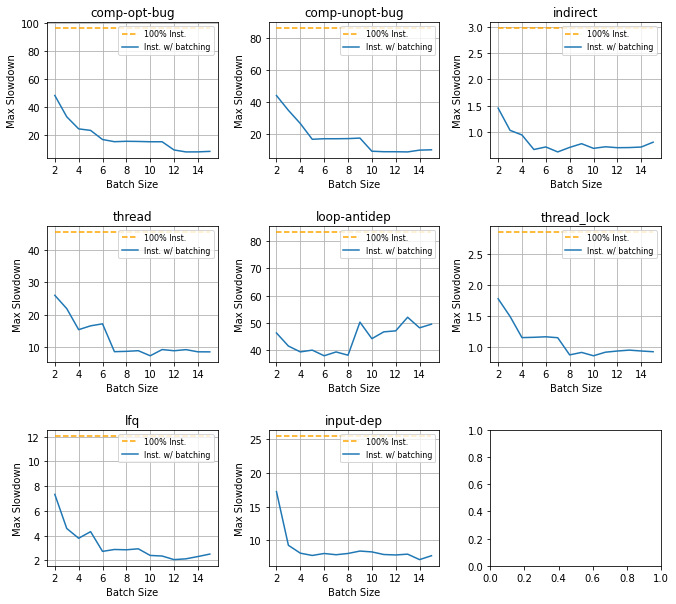

In [13]:
import matplotlib.pyplot as plt
import math

fig, axs = plt.subplots(math.ceil(len(testnames)/3), 3, figsize=(11, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

i = 0
for testname, results in run_dict.items():
    print(f"Started \"{testname}\"")
    batch_overhead = np.mean(results["batchinst"][:,:,0] / results["noinst"], axis=0)
    allinst_avg_overhead = np.mean(results["allinst"] / results["noinst"])
    line_handle, = axs[i//3][i%3].plot(batch_range, batch_overhead, label="Instrumentation w/ batching")
    axs[i//3][i%3].set_xticks(batch_range[::2])
    
    allinst_handle = axs[i//3][i%3].hlines(y=allinst_avg_overhead, xmin=batch_range[0], xmax=batch_range[-1], linestyles='dashed', color='orange')
    #baseline_handle = axs[i//3][i%3].hlines(y=1.0, xmin=batch_range[0], xmax=batch_range[-1], linestyles='dashed')
    axs[i//3][i%3].set_title(testname)
    axs[i//3][i%3].set_xlabel('Batch Size')
    axs[i//3][i%3].set_ylabel('Max Slowdown')
    axs[i//3][i%3].grid()
    axs[i//3][i%3].legend([allinst_handle, line_handle], \
                          ["100% Inst.", "Inst. w/ batching"], \
                          prop={"size":8},
                          loc='best')
    
    i += 1

In [14]:
fig.savefig('graphs/smart_balance_revised.jpg', dpi=400)

Following parses TSV results outputs

In [2]:
# Parse results

results_dir = Path('results/tsv_results_opt_20_runs')

batch_inc = 1
batch_start, batch_end = 2, 15
batch_range = np.arange(batch_start, batch_end + batch_inc, batch_inc)

stoch_inc = 10
stoch_start, stoch_end = 10, 90
stoch_range = np.arange(stoch_start, stoch_end + stoch_inc, stoch_inc)
num_runs = 20


def parse_run_file(dpath, run_dict, run_idx, stoch_idx, batch_idx, ty):
    with open(dpath, 'r') as f:
        lines = list(f.readlines())
        
    header = re.compile(r'--> Test (\S+) <--')
    time = re.compile(r'Time:\s*(.*)')
        
    run_results = [lines[i::2] for i in range(2)]
    compiler = [(header, str), (time, float)]
    full_results = [[compiler[i][1](compiler[i][0].match(elems).group(1)) \
                         for elems in run_key] for i, run_key in enumerate(run_results)]
    full_results[0] = [Path(x).name.split('.')[1] \
                       if Path(x).name.split('.')[0] == "batch" \
                       else Path(x).name.split('.')[0] for x in full_results[0]]
    full_results = list(zip(*full_results))
    for tup in full_results:
        run_dict[tup[0]][ty][run_idx][stoch_idx][batch_idx] = np.array(tup[1:])
    

    
def parse_batch_file(dpath, run_dict, run_idx, stoch_idx, batch_idx):
    with open(dpath, 'r') as f:
        lines = list(f.readlines())
        
    header = re.compile(r'--> Batch: batch.(\S+) <--')
    max_time = re.compile(r'Max Time:\s*(.*)')
    accuracy = re.compile(r'Relative Violations:\s*(.*)')
    
    run_results = [lines[i::3] for i in range(3)]

    compiler = [(header, str), (max_time, float), (accuracy, int)]
    full_results = [[compiler[i][1](compiler[i][0].match(elems).group(1)) \
                         for elems in run_key] for i, run_key in enumerate(run_results)]
    
    full_results = list(zip(*full_results))
    for tup in full_results:
        run_dict[tup[0]]["batchinst"][run_idx][stoch_idx][batch_idx] = np.array(tup[1:])

    
    

testnames = [p.stem for p in Path('tests').glob("*.c")]
run_dict = {key: { "noinst" : np.ones([num_runs, stoch_range.size, batch_range.size]), \
                            "allinst": np.ones([num_runs, stoch_range.size, batch_range.size]), \
                            "batchinst": np.ones([num_runs, stoch_range.size, batch_range.size, 2]) \
                          } for key in testnames }

for batch_size in batch_range:
    for stoch_size in stoch_range:
        for run_no in range(1, num_runs+1):
            parse_batch_file(results_dir / f"run_{run_no}_{stoch_size}_{batch_size}.res", run_dict, \
                             run_no-1, (stoch_size - stoch_start) // stoch_inc, \
                             (batch_size - batch_start) // batch_inc )
            parse_run_file(results_dir / f"allinst_run_{run_no}_{stoch_size}_{batch_size}.res", run_dict, \
                             run_no-1, (stoch_size - stoch_start) // stoch_inc, \
                           (batch_size - batch_start) // batch_inc, "allinst" )
            parse_run_file(results_dir / f"noinst_run_{run_no}_{stoch_size}_{batch_size}.res", run_dict, \
                             run_no-1, (stoch_size - stoch_start) // stoch_inc, \
                           (batch_size - batch_start) // batch_inc, "noinst" )

#for k, secs in run_dict.items():
#    for ty, res in secs.items():
#        run_dict[k][ty] = np.mean(res, axis=0)

Started "comp-opt-bug"
Started "comp-unopt-bug"
Started "indirect"
Started "thread"
Started "loop-antidep"
Started "thread_lock"
Started "lfq"
Started "input-dep"


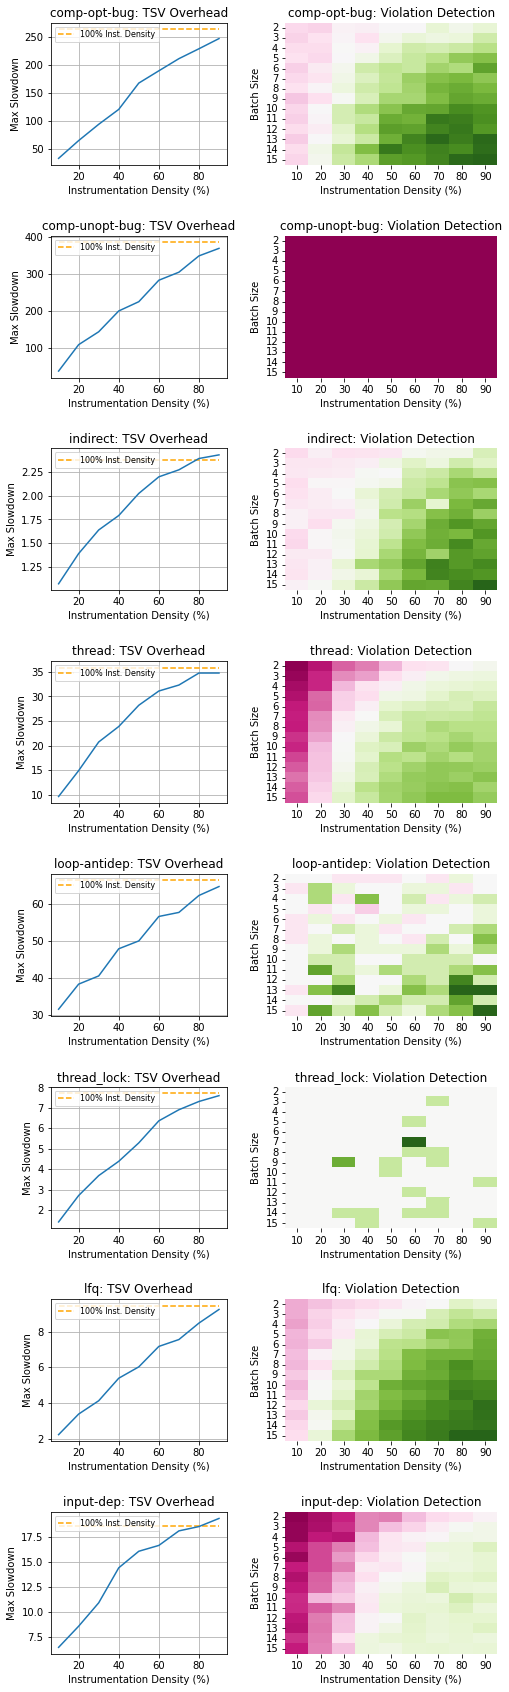

In [13]:
import matplotlib.pyplot as plt
import math

testnames = run_dict.keys()
fig, axs = plt.subplots(len(testnames), 2, figsize=(8, 30), gridspec_kw={'width_ratios': [2.5, 3]})
plt.subplots_adjust(hspace=0.5, wspace=0.3)

i = 0
for testname, results in run_dict.items():
    print(f"Started \"{testname}\"")
    stoch_overhead = np.mean(results["batchinst"][:,:,:,0] / results["noinst"], axis=0)
    allinst_avg_overhead = np.mean(results["allinst"] / results["noinst"])
    
    line_handle, = axs[i][0].plot(stoch_range, np.mean(stoch_overhead, axis=1))
    allinst_handle = axs[i][0].hlines(y=allinst_avg_overhead, xmin=stoch_range[0], xmax=stoch_range[-1], linestyles='dashed', color='orange')
    #baseline_handle = axs[i][0].hlines(y=1.0, xmin=stoch_range[0], xmax=stoch_range[-1], linestyles='dashed')
    axs[i][0].set_title(testname + ': TSV Overhead')
    axs[i][0].set_xlabel('Instrumentation Density (%)')
    axs[i][0].set_ylabel('Max Slowdown')
    axs[i][0].grid()
    
    axs[i][0].legend([allinst_handle], \
                     ["100% Inst. Density"], \
                     prop={"size":8})
    
    mean_violation_accuracy = np.mean(results["batchinst"][:,:,:,1], axis=0)
    s = sns.heatmap(mean_violation_accuracy.T, cmap="PiYG", center=0, cbar=False,
                 xticklabels=stoch_range,
                 yticklabels=batch_range,
                 ax=axs[i][1])
    s.set(ylabel='Batch Size', xlabel='Instrumentation Density (%)')
    axs[i][1].set_title(testname + f": Violation Detection")
    
    i += 1

In [14]:
fig.savefig('graphs/tsv_stochastic_revised_cbar.jpg', dpi=400)

TSV bug parsing

In [5]:
# Parse results

num_runs = 500
log_dir = Path(f"violation_details_{num_runs}_runs")

stoch_inc = 5
stoch_start, stoch_end = 5, 95
stoch_range = np.arange(stoch_start, stoch_end + stoch_inc, stoch_inc)

class ViolationPair():
    def __init__(self, i1, i2):
        self.i1, self.i2 = (i1, i2) if i1 < i2 else (i2, i1)

    #def __eq__(self, other):
    #    return  (self.i1 == other.i1 and self.i2 == other.i2) or \
    #            (self.i1 == other.i2 and self.i2 == other.i1)
#
    #def __hash__(self):
    #    return hash((self.i1, self.i2)) ^ hash((self.i2, self.i1))
    #
    def __repr__(self):
        return f"|{self.i1}, {self.i2}|"
    
    def __str__(self):
        return f"|{self.i1}, {self.i2}|"


def parse_log_file(testname):
    comp_str = r"Instructions \((\d+)\s*,\s*(\d+)\s*\)"
    for stoch_size in stoch_range:
        merge_content = []
        stoch_idx = (stoch_size - stoch_start) // stoch_inc
        for run_no in range(1, num_runs+1):
            run_idx = run_no-1
            # Read file for test
            fpath = log_dir / f"{testname}.run_{run_no}_{stoch_size}.log"
            with open(fpath, 'r') as f:
                merge_content += list(f.readlines())

        for line in merge_content:
            re_tup = re.search(comp_str, line).group(1,2)
            vp = str(ViolationPair(*re_tup))
            if testname == "indirect":
                print(re_tup, vp)
            if vp not in run_bug_dist[testname]:
                run_bug_dist[testname][vp] = np.zeros([stoch_range.size], dtype=int)
            run_bug_dist[testname][vp][stoch_idx] += 1
        

testnames = { x.name.split('.')[0] for x in log_dir.glob('*.log') }
run_bug_dist = {key: { } for key in testnames }

print(testnames)
for testname in testnames:
    parse_log_file(testname)
    
print(run_bug_dist['thread_lock'])

{'comp-opt-bug', 'lfq', 'indirect', 'thread_lock', 'input-dep', 'loop-antidep', 'comp-unopt-bug', 'thread'}
('7', '10') |10, 7|
('9', '8') |8, 9|
('8', '9') |8, 9|
('8', '9') |8, 9|
('9', '8') |8, 9|
('8', '9') |8, 9|
('10', '7') |10, 7|
('8', '9') |8, 9|
('9', '8') |8, 9|
('8', '9') |8, 9|
('8', '9') |8, 9|
('8', '10') |10, 8|
('8', '10') |10, 8|
('8', '9') |8, 9|
('7', '10') |10, 7|
('9', '8') |8, 9|
('7', '10') |10, 7|
('9', '8') |8, 9|
('10', '7') |10, 7|
('8', '10') |10, 8|
('9', '8') |8, 9|
('8', '9') |8, 9|
('7', '10') |10, 7|
('8', '9') |8, 9|
('7', '10') |10, 7|
('8', '9') |8, 9|
('10', '7') |10, 7|
('10', '7') |10, 7|
('7', '10') |10, 7|
('10', '7') |10, 7|
('9', '8') |8, 9|
('8', '9') |8, 9|
('8', '10') |10, 8|
('7', '10') |10, 7|
('9', '8') |8, 9|
('8', '10') |10, 8|
('8', '9') |8, 9|
('8', '9') |8, 9|
('10', '7') |10, 7|
('7', '10') |10, 7|
('8', '9') |8, 9|
('9', '8') |8, 9|
('7', '10') |10, 7|
('8', '10') |10, 8|
('9', '8') |8, 9|
('7', '10') |10, 7|
('10', '7') |10, 7|


('8', '10') |10, 8|
('10', '7') |10, 7|
('8', '9') |8, 9|
('8', '9') |8, 9|
('8', '10') |10, 8|
('10', '8') |10, 8|
('10', '7') |10, 7|
('8', '10') |10, 8|
('9', '8') |8, 9|
('10', '7') |10, 7|
('8', '10') |10, 8|
('9', '8') |8, 9|
('8', '9') |8, 9|
('10', '8') |10, 8|
('8', '9') |8, 9|
('8', '9') |8, 9|
('10', '7') |10, 7|
('10', '7') |10, 7|
('10', '7') |10, 7|
('10', '8') |10, 8|
('8', '9') |8, 9|
('8', '9') |8, 9|
('7', '10') |10, 7|
('8', '9') |8, 9|
('10', '7') |10, 7|
('8', '9') |8, 9|
('9', '8') |8, 9|
('8', '9') |8, 9|
('8', '9') |8, 9|
('10', '8') |10, 8|
('10', '7') |10, 7|
('8', '9') |8, 9|
('10', '8') |10, 8|
('8', '9') |8, 9|
('10', '7') |10, 7|
('8', '10') |10, 8|
('8', '9') |8, 9|
('8', '10') |10, 8|
('8', '10') |10, 8|
('8', '9') |8, 9|
('7', '10') |10, 7|
('8', '9') |8, 9|
('8', '9') |8, 9|
('9', '8') |8, 9|
('10', '7') |10, 7|
('10', '8') |10, 8|
('9', '8') |8, 9|
('10', '7') |10, 7|
('8', '10') |10, 8|
('8', '9') |8, 9|
('7', '10') |10, 7|
('8', '9') |8, 9|
('8', '1

('9', '8') |8, 9|
('10', '7') |10, 7|
('8', '9') |8, 9|
('10', '7') |10, 7|
('10', '8') |10, 8|
('9', '8') |8, 9|
('10', '7') |10, 7|
('7', '10') |10, 7|
('8', '10') |10, 8|
('7', '10') |10, 7|
('10', '8') |10, 8|
('8', '9') |8, 9|
('8', '9') |8, 9|
('10', '7') |10, 7|
('10', '8') |10, 8|
('10', '7') |10, 7|
('10', '8') |10, 8|
('8', '9') |8, 9|
('10', '7') |10, 7|
('9', '8') |8, 9|
('8', '9') |8, 9|
('10', '7') |10, 7|
('8', '9') |8, 9|
('10', '7') |10, 7|
('7', '10') |10, 7|
('8', '9') |8, 9|
('7', '10') |10, 7|
('8', '9') |8, 9|
('8', '10') |10, 8|
('10', '7') |10, 7|
('9', '8') |8, 9|
('8', '10') |10, 8|
('8', '10') |10, 8|
('8', '9') |8, 9|
('8', '9') |8, 9|
('8', '9') |8, 9|
('10', '8') |10, 8|
('10', '8') |10, 8|
('8', '9') |8, 9|
('7', '10') |10, 7|
('10', '7') |10, 7|
('8', '9') |8, 9|
('8', '10') |10, 8|
('8', '9') |8, 9|
('8', '10') |10, 8|
('8', '9') |8, 9|
('7', '10') |10, 7|
('9', '8') |8, 9|
('8', '10') |10, 8|
('10', '7') |10, 7|
('8', '10') |10, 8|
('10', '8') |10, 8|


{'|17, 3|': array([0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 5, 0, 0, 1, 1, 0, 0, 0, 0])}


comp-opt-bug: 4
lfq: 38
indirect: 3
thread_lock: 1
input-dep: 7
loop-antidep: 1
comp-unopt-bug: 0
thread: 19
comp-opt-bug
lfq
indirect
thread_lock
input-dep
loop-antidep
comp-unopt-bug
NO BUGS for comp-unopt-bug
thread


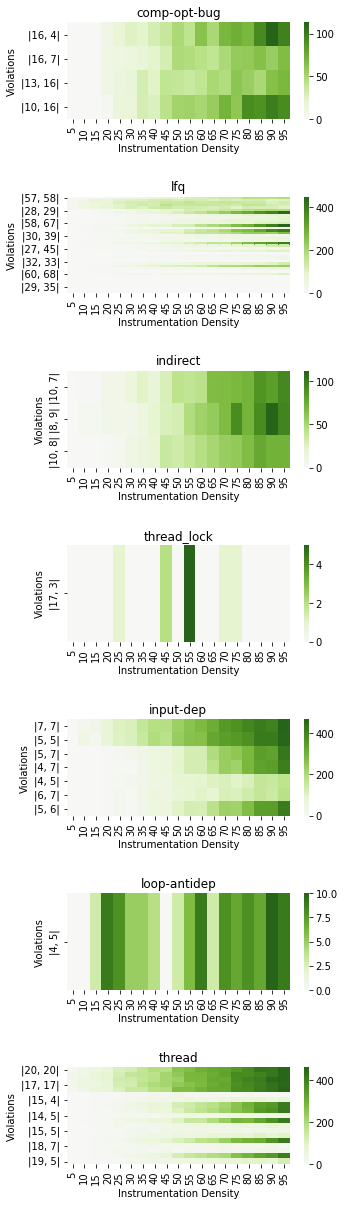

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import math

for testname, violations in run_bug_dist.items():
    print(f"{testname}: {len(violations)}")

num_tests = len([k for k in run_bug_dist.keys() if run_bug_dist[k]])
fig, axs = plt.subplots(num_tests, 1, figsize=(5, 3*(num_tests)))
plt.subplots_adjust(hspace=0.8)

i = 0
for testname, test_dist in run_bug_dist.items():
    print(f"{testname}")
    test_frame = pd.DataFrame.from_dict(test_dist, orient='index')
    test_frame.columns = [(k+1)*5 for k in list(test_frame.columns)]
    if not test_frame.empty:
        s = sns.heatmap(test_frame, cmap='PiYG', center = 0, ax=axs[i])
        s.set(xlabel='Instrumentation Density', ylabel='Violations')
        axs[i].set_title(f"{testname}")
        i += 1
    else:
        print(f"NO BUGS for {testname}")

lfq
I:38 | Num vp: 38


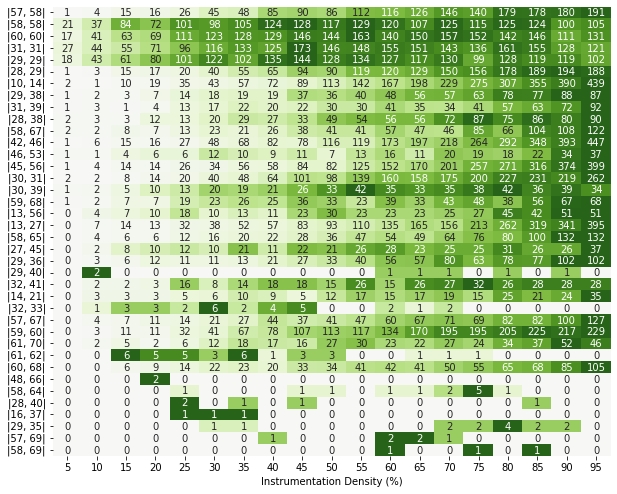

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import math

#for testname, violations in run_bug_dist.items():
#    print(f"{testname}: {len(violations)}")

fig = plt.figure(figsize=(10, 8))
plt.subplots_adjust(bottom=0.10)
    
tests = [k for k in run_bug_dist.keys() if run_bug_dist[k]]
tests = ['lfq']
num_tests = len(tests)
#subfigs = fig.subfigures(num_tests, 1)
subfigs = [fig]

# One subfig for every test
for ind, subfig in enumerate(subfigs):
    testname = tests[ind]
    print(f"{testname}")
    test_dist = run_bug_dist[testname]
    if not test_dist:
        print(f"NO BUGS for {testname}")
        continue
    
    num_vp = len(test_dist)
    axs = subfig.subplots(num_vp, 1, gridspec_kw={'hspace': 0})
    axs = np.array([axs]) if type(axs) != np.ndarray else axs
    i = 0
    for vp, arr in test_dist.items():
        arr = arr[:, None].T
        if i == num_vp - 1:
            s = sns.heatmap(arr, cmap='PiYG', center = 0, cbar=False, 
                            annot=True, fmt='.3g',
                            xticklabels=stoch_range,
                            yticklabels=[vp],
                            ax=axs[i])
        else: 
            s = sns.heatmap(arr, cmap='PiYG', center = 0, cbar=False, 
                            annot=True, fmt='.3g',
                            xticklabels=[],
                            yticklabels=[vp],
                            ax=axs[i])
            
        s.set_yticklabels(s.get_yticklabels(), rotation = 0)
        i += 1
        
    s.set(xlabel='Instrumentation Density (%)')
    
    print(f"I:{i} | Num vp: {num_vp}")
    
    

In [41]:
subfigs[0].savefig('figs/bug_details.jpg', dpi=400)

In [135]:
import matplotlib
print(matplotlib.__version__)

3.3.4
